## Car with Obstacles

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra

┌ Info: Recompiling stale cache file /home/taylor/.julia/compiled/v1.1/TrajectoryOptimization/UVgeA.ji for TrajectoryOptimization [c79d492b-0548-5874-b488-5a62c1d9d0ca]
└ @ Base loading.jl:1184
┌ Warning: Package TrajectoryOptimization does not have Test in its dependencies:
│ - If you have TrajectoryOptimization checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TrajectoryOptimization
└ Loading Test into TrajectoryOptimization from project dependency, future warnings for TrajectoryOptimization are suppressed.


Import the car model

In [2]:
model = Dynamics.car_model
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [3]:
T = Float64;

Define initial and goals states

In [4]:
x0 = [0.; 0.; 0.]
xf = [1.; 1.; 0.]

3-element Array{Float64,1}:
 1.0
 1.0
 0.0

Define a cost function, e.g., quadratic

In [5]:
Q = (1.0e-2)*Diagonal(I,n)
R = (1.0)*Diagonal(I,m)
Qf = 1000.0*Diagonal(I,n)
cost = LQRCost(Q, R, Qf, xf);

Define obstacles

In [6]:
# create obstacle constraints
r_circle = 0.1
circles = ((0.4,0.25,r_circle),(0.8,0.65,r_circle),(1.0,0.85,r_circle))
n_circles = length(circles)

function circle_obs(c,x,u)
    for i = 1:n_circles
        c[i] = TrajectoryOptimization.circle_constraint(x,circles[i][1],circles[i][2],circles[i][3])
    end
    return nothing
end

obs = Constraint{Inequality}(circle_obs,n,m,n_circles,:obs);

Define a problem

In [7]:
N = 101 # number of knot points
dt = 0.1 # total time

U = [rand(m) for k = 1:N-1] 

obj = Objective(cost,N) # objective with same stagewise costs
constraints = Constraints([obs],N) # constraints at each stage
    
prob = Problem(model,obj, constraints=constraints, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob,U); # initialize problem with controls

prob_uncon = Problem(model,obj, constraints=constraints, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob_uncon,U); # initialize problem with controls

Solve problem

In [8]:
solve!(prob, ALTROSolverOptions{T}(verbose=true)) # solve with iLQR

Solve unconstrained problem

In [9]:
solve!(prob_uncon, iLQRSolverOptions{T}(verbose=true)) # solve with iLQR

    iter cost          expected    z         α         ρ         dJ        grad      zero_count info                                              
____----------------------------------------------------------------------------------------------------------------------------------------------
    1     16330.331467  7533.8946   0.118171  0.25      0e+00     890.2872  3.747671 0          
    2     10517.853425  7144.36282  0.813575  0.25      0e+00     5812.478  2.050171 0          
    3     1626.2535653  10517.7133  0.845393  1         0e+00     8891.6    1.0289   0          
    4     191.50218852  1219.6407   1.176372  0.5       0e+00     1434.751  0.509576 0          
    5     12.88482232   191.457063  0.932937  1         0e+00     178.6174  0.641901 0          
    6     0.5815405301  12.8424792  0.958015  1         0e+00     12.30328  0.165779 0          
    7     0.05384337    0.53935959  0.978377  1         0e+00     0.527697  0.205799 0          
    8     0.042178918   0.0

0.04188264104081289

In [10]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N]

x_uncon = [prob_uncon.X[k][1] for k = 1:N]
y_uncon = [prob_uncon.X[k][2] for k = 1:N];

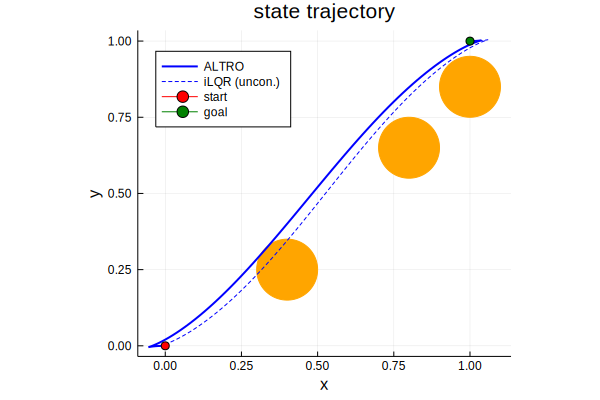

In [11]:
plot()
plot_obstacles(circles,:orange)
plot!(x,y,xlabel="x",ylabel="y",label="ALTRO",legend=:topleft,color=:blue,width=2,ratio=:equal,title="state trajectory")
plot!(x_uncon,y_uncon,xlabel="x",ylabel="y",label="iLQR (uncon.)",legend=:topleft,color=:blue,linestyle=:dash,width=1,ratio=:equal,title="state trajectory")

plot!((x[1],y[1]),marker=:circle,color=:red,label="start")
plot!((x[end],y[end]),marker=:circle,color=:green,label="goal")

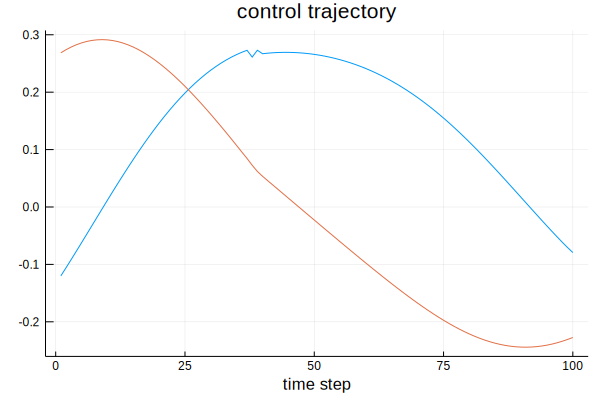

In [12]:
plot(prob.U,xlabel="time step",legend=:none,title="control trajectory")